In [34]:
# To access our dataset file
from google.colab import drive
drive.mount('/content/drive/')
dataset_path = '/content/drive/Shareddrives/AAX/Resources/dataset_Seminar2/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [35]:
# Importing modules, uncomment pip installations if importing results in errors

import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, classification_report, hinge_loss


#**1) Part I: Data preparation & analysis**

##**1.1) Create a function/script that takes SkelletonPoints as input and plots the corresponding pose. Your plotting function should also display the label associated with the pose being plotted.**

We first load the skeleton points and the labels in two pandas dataframes and create a function to plot the skeleton pose from a single row.

In [36]:
# Load data (corrected)
skelleton_ds = pd.read_csv(dataset_path + 'Train_skelletonpoints.csv', sep=",", header=None)
skelleton_lb = pd.read_csv(dataset_path + 'Train_labels.csv', header=None)

# Extracting the value and converting it to int (the dataframe is (1, 1000))
value = int(skelleton_lb[1].iloc[0])

# We assign the name of the pose to the labels
labels =  ['wave', 'push', 'crouch', 'sitdown', 'bend']


In [37]:
def plot_skeleton_pose(row_index, skeleton_df, skeleton_lb, labels):
    """
    Plots a skeleton pose with proper handling for array labels.

    Parameters:
    - row_index: Index of the row to plot (0-based)
    - skeleton_df: DataFrame with skeleton data (54 columns)
    - skeleton_lb: 1D array of label indices (shape: (n_samples,))
    - labels: List of label names
    """
    # Validate row index
    if row_index >= len(skeleton_df):
        raise ValueError(f"Row index {row_index} is out of bounds (max: {len(skeleton_df)-1})")

    # Extract pose data
    row = skeleton_df.iloc[row_index]
    x_coords = -row[:18].values  # Flip x-axis
    y_coords = row[18:36].values
    confidences = row[36:54].values

    # Get label from array (assuming skeleton_lb is numpy array)
    label_idx = int(skeleton_lb[row_index])  # Direct array access
    label = labels[label_idx-1]  # Get corresponding text label

    # MPII connection template (0-based indices)
    connections = [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 4),
        (1, 5),
        (5, 6),
        (6, 7),
        (1, 8),
        (8, 9),
        (9, 10),
        (1, 11),
        (11, 12),
        (12, 13),
        (0, 14),
        (0, 15),
        (14, 16),
        (15, 17),
        (2, 5),
        (8, 11)
    ]

    # Create figure
    plt.figure(figsize=(8, 8))

    # Plot joints (mirrored y-axis)
    for i, (x, y, conf) in enumerate(zip(x_coords, y_coords, confidences)):
        if conf > 0.1:
            plt.plot(-y, x, 'o', markersize=8, label=f'Joint {i+1}' if i == 0 else "")

    # Draw limbs
    for i, j in connections:
        if i < 18 and j < 18:  # Joint indices safety check
            if confidences[i] > 0.1 and confidences[j] > 0.1:
                plt.plot([-y_coords[i], -y_coords[j]],
                        [x_coords[i], x_coords[j]],
                        'b-', linewidth=2)

    plt.gca().set_aspect('equal')
    plt.title(f"Pose {row_index}: {label}")
    plt.legend()
    plt.grid(True)
    plt.show()


We then try out the function with one of the poses of the dataset.

<ipython-input-37-7053995c6a4a>:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label_idx = int(skeleton_lb[row_index])  # Direct array access


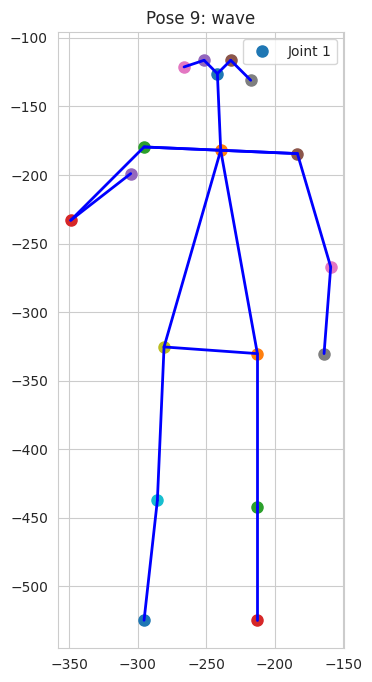

In [38]:
num_skeleton = 9


plot_skeleton_pose(num_skeleton, skelleton_ds, skelleton_lb, labels)  # Plot second row

The pose is plotted correctly.


##**1.2) Now, focus on the CSI data (for instance, from Train features.csv) and implement the code for plotting the average CSI amplitude per subcarrier. Such a plot should allow for understanding the status of the channel at a given specific moment and for a specific subcarrier.**

We first create the function to plot the amplitude of a singular collection of subcarriers. The function will receive a reading of 30 subcarriers and print the mean amplitude of each subcarrier.

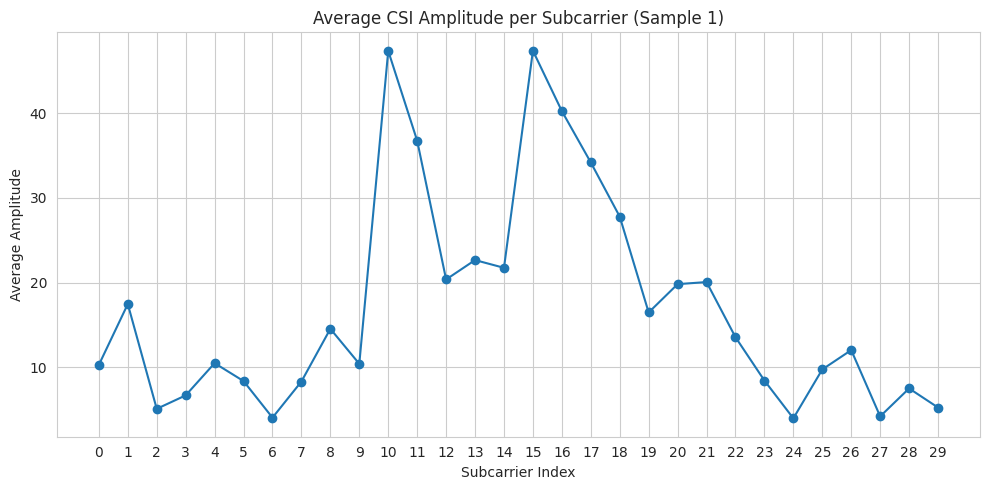

In [39]:
def plot_avg_csi_amplitude(train_features, sample_idx):
    """Plot average CSI amplitude per subcarrier for a specific sample"""
    # Get one sample and reshape from (1000, 270) to (1000, 30, 3, 3)

    csi_data = train_features.reshape(-1,30,3,3)
    csi_matrix = csi_data[sample_idx]

    # Compute average amplitude per subcarrier
    avg_amplitudes = np.mean(np.abs(csi_matrix), axis=(1, 2))

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(30), avg_amplitudes, marker='o')
    plt.title(f'Average CSI Amplitude per Subcarrier (Sample {sample_idx})')
    plt.xlabel('Subcarrier Index')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.xticks(range(30))
    plt.tight_layout()
    plt.show()

# Load the dataset
train_features = pd.read_csv(dataset_path + 'Train_features.csv', sep=",", header=None).values.astype(float)

# Example usage:
plot_avg_csi_amplitude(train_features, 1)


##**1.3) Finally, plot the distribution of the CSI amplitude across each subcarrier for each class.**

Now, we create and execute a function to plot the density of the labels assigned to each subcarrier. That is, how many times a certain subcarrier has been assigned with each class (pose) across all the readings (1000).

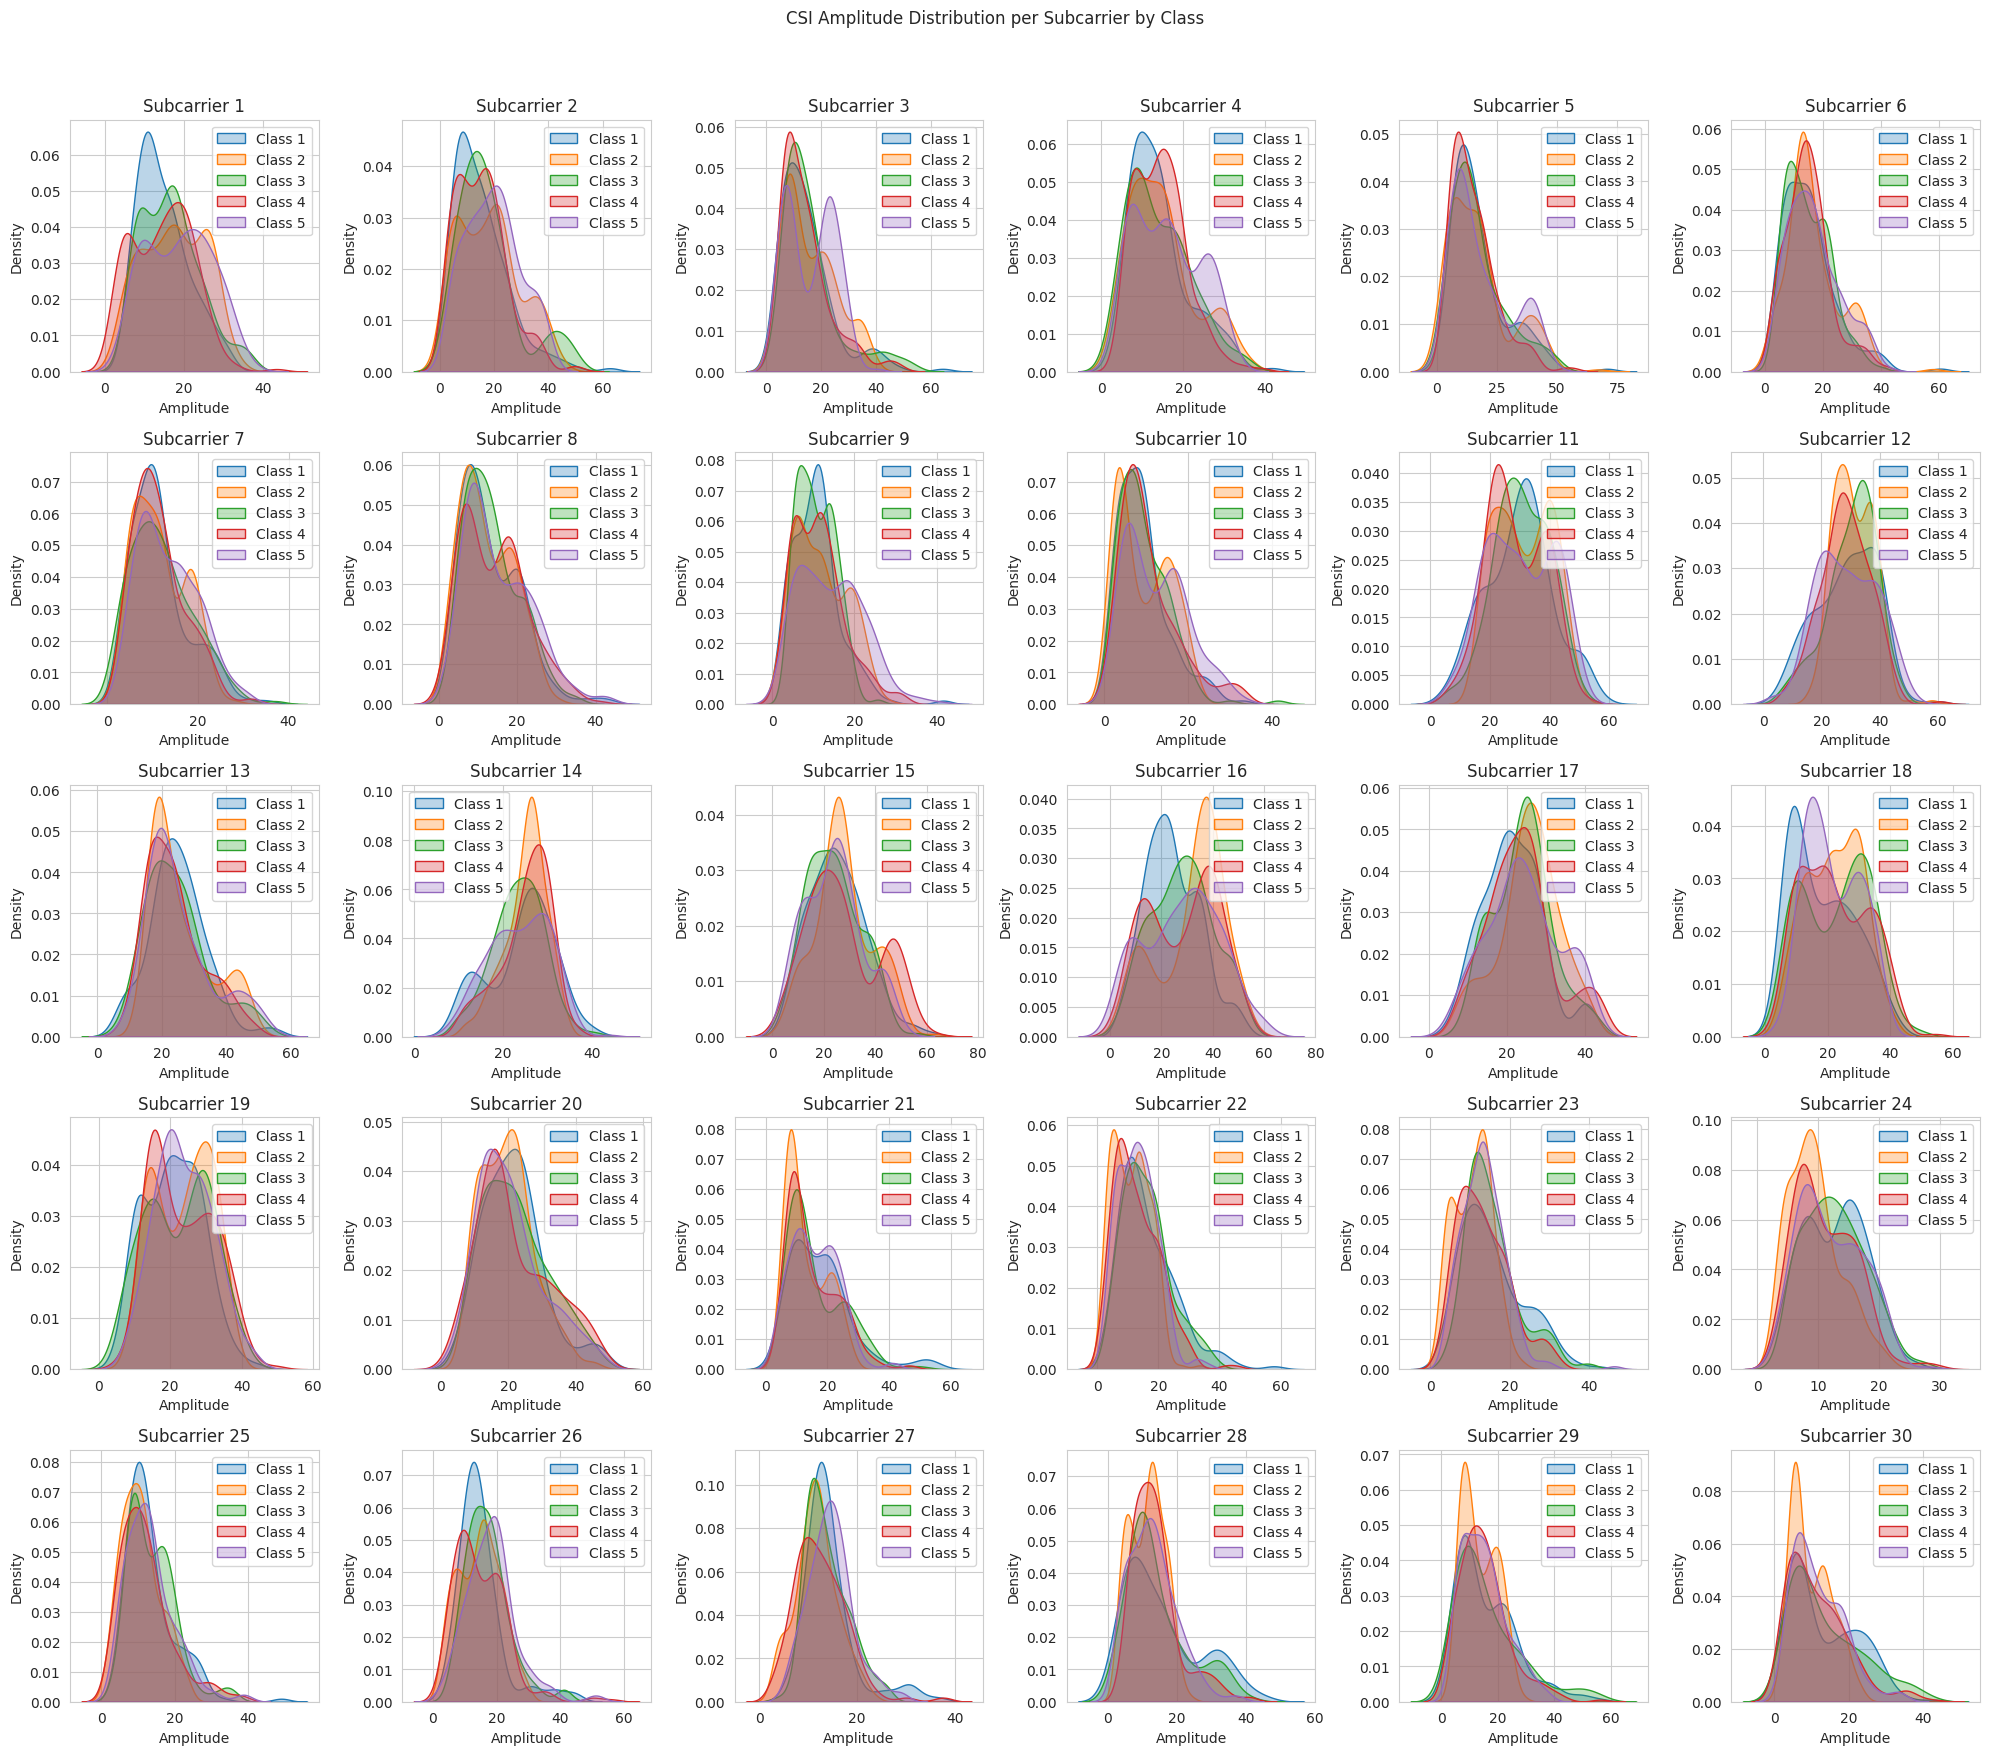

In [40]:

def plot_csi_amplitude_distributions(features_path, labels_path, num_subcarriers=30, num_tx=3, num_rx=3):
    """
    Plots CSI amplitude distributions per subcarrier for each class.

    Args:
        features_path: Path to Train_features.csv
        labels_path: Path to Train_labels.csv
        num_subcarriers: Number of subcarriers (default: 30)
        num_tx: Number of transmitter antennas (default: 3)
        num_rx: Number of receiver antennas (default: 3)
    """
    # Load and preprocess data
    train_features = pd.read_csv(features_path, header=None).values.astype(float)
    train_labels = pd.read_csv(labels_path, header=None).values.astype(int)

    # Reshape and compute average amplitudes
    csi_data = train_features.reshape(-1, num_subcarriers, num_tx, num_rx)
    amplitudes = np.abs(csi_data)
    avg_amplitudes = np.mean(amplitudes, axis=(2, 3))  # Average over Tx and Rx

    # Get class information
    classes = np.unique(train_labels)
    num_plots_row = int(np.ceil(np.sqrt(num_subcarriers)))

    # Set up plot
    plt.figure(figsize=(20, 20))
    sns.set_style("whitegrid")
    plt.suptitle('CSI Amplitude Distribution per Subcarrier by Class', y=1.02)

    # Plot each subcarrier
    for subcarrier in range(num_subcarriers):
        plt.subplot(num_plots_row, num_plots_row, subcarrier+1)

        for class_label in classes:
            class_mask = (train_labels.flatten() == class_label)
            sns.kdeplot(avg_amplitudes[class_mask, subcarrier],
                        label=f'Class {class_label}',
                        fill=True,
                        alpha=0.3)

        plt.title(f'Subcarrier {subcarrier+1}')
        plt.xlabel('Amplitude')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_csi_amplitude_distributions( features_path= dataset_path + 'Train_features.csv', labels_path= dataset_path + 'Train_labels.csv')

With this we can see how each subcarrier has a different distribution of classes.

#**2) Part II: Model implementation**

##**2.1) Create a module that loads the training data and fits it into an SVM. You can leverage existing libraries that implement SVMs (e.g., pytorch).**

We have decided to use Scikit-learn built in SVM to implement the model. We have scaled the data using Min-Max Scaling.

In [41]:
# Split data
X_train = pd.read_csv(dataset_path + 'Train_features.csv', sep=",", header=None).values.astype(float)
X_test = pd.read_csv(dataset_path + 'Test_features.csv', sep=",", header=None).values.astype(float)
y_train = pd.read_csv(dataset_path + 'Train_labels.csv', header=None).values.astype(int)
y_test = pd.read_csv(dataset_path + 'Test_labels.csv', header=None).values.astype(int)


scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
y_train = y_train.flatten()


# ovo = one-versus-one, probability = True computes the distributions for later
clf = svm.SVC(decision_function_shape='ovo',probability=True)

clf.fit(X_train_scaled, y_train)



SVC(decision_function_shape='ovo', probability=True)

##**2.2) Generate predictions on the test dataset using the SVM trained in the previous step.**

We generate the prediction

In [42]:
y_test = y_test.flatten()

X_test_scaled = scaler.transform(X_test)


y_pred = clf.predict(X_test_scaled)

##**2.3) For evaluating the SVM, you should define one or more success rate metrics.**

To evaluate the SVM, Scikit gives us some built-in tools, like a classification report and a method to calculate the logistic/cross-entropy loss.

In [43]:
y_prob = clf.predict_proba(X_test_scaled)
loss = log_loss(y_test, y_prob)
cr = classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5])
print(cr)
print(f"Log Loss: {loss}")

              precision    recall  f1-score   support

           1       0.78      0.74      0.76        42
           2       0.63      0.82      0.71        39
           3       0.74      0.83      0.78        35
           4       0.81      0.55      0.66        38
           5       0.70      0.67      0.69        46

    accuracy                           0.72       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200

Log Loss: 0.7388525495348846


- Precision: Of all the times the model predicted this class, how many times was it correct? (Low precision means many false positives.)

- Recall: Of all actual instances of this class, how many did the model correctly identify? (Low recall means many false negatives.)

- F1-Score: The harmonic mean of precision and recall — a balance between the two.

- Support: The number of true samples for each class in the test set.

We can interpret those results. For example, for Class 4, the model is very precise (0.81), but recall is low (0.55), meaning it finds the right ones when it guesses this class, but it misses a lot of actual class 4 instances (around half of all of them).

An overall accuracy of 0.72 is quite good, although it could be better.

As for the logistic loss, we have 5 types of poses, so we have 5 labels, and a log loss of choosing randomly among these 5 labels would result in the following error:
$$
-\log\left(\frac{1}{5}\right) = \log(5) \approx 1.61
$$

Therefore, our model has room for improvement, but it is moderately good.



#**3) Part III: Model improvements**

After finishing the model, we collaborated with the group consisting of Pau, Sergi, and Xavi and tried different ways to optimize the performance.

One of the things we tried was using different functions to scale, normalize or transform the data, and found that PowerTransform was the option that gave the best accuracy.

The PowerTransformer function is used to make numerical data closer resemble a Gaussian distribution, enhancing the algorithms that depend on the data being of normal distribution. The function includes two ways of doing so.

Box-Cox transformation follows the formula:

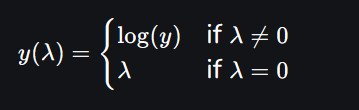

Yeo-Johnson transformation follows the formula:

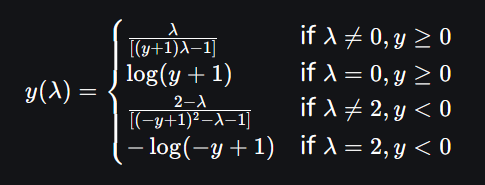

Both methods basically do the same thing: they try to correct skewed data or any kurtosis to make the data resemble a Gaussian normal distribution. Yeo-Johnsson is an extension of Box-Cox that supports negative values. More detailed information on how both algorithms work can be found in this [short article](https://www.geeksforgeeks.org/powertransformer-in-scikit-learn/).

In our case, we have negative values in the data, so we use Yeo-Johnson, which is the default method. We initialize the PowerTransformer object with the default "standarize" flag to True, which processes the data to have a mean of 0 and std of 1.

Another change we made was the way the SVC object was instantiated. We tried different kernels and found that the best for our case was the RBF (Radial Basis Function). For RBF, the gamma parameter specifies the value of $\gamma$ in $\exp(-\gamma \|x-x'\|^2)$. A low $\gamma$ makes each individual value affect the training less. The C parameter is universal among all kernels and acts as a weight on the penalty for the distance of samples. Elements are not always perfectly separable in a hyperplane, so the C parameter controls the amount of error a sample may have and still be part of the boundary. The bigger the C, the stricter the prediction is. More information in the [documentation for SVM in Scikit](https://scikit-learn.org/stable/modules/svm.html).

The best combination we found was $C = 10$, gamma $= 0.01$.


In [44]:
from sklearn.preprocessing import PowerTransformer

X_train = pd.read_csv(dataset_path + 'Train_features.csv', sep=",", header=None).values.astype(float)
X_test = pd.read_csv(dataset_path + 'Test_features.csv', sep=",", header=None).values.astype(float)
y_train = pd.read_csv(dataset_path + 'Train_labels.csv', header=None).values.astype(int)
y_test = pd.read_csv(dataset_path + 'Test_labels.csv', header=None).values.astype(int)

### New/Changed ###
scaler = PowerTransformer()
###################
X_train_scaled = scaler.fit_transform(X_train)
y_train = y_train.flatten()

### New/Changed ###
clf = svm.SVC(decision_function_shape='ovo',probability=True, gamma=0.01, C=10)
###################

clf.fit(X_train_scaled, y_train)

y_test = y_test.flatten()

X_test_scaled = scaler.transform(X_test)


y_pred = clf.predict(X_test_scaled)

y_prob = clf.predict_proba(X_test_scaled)
loss = log_loss(y_test, y_prob)
cr = classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5])
print(cr)
print(f"Log Loss: {loss}")

              precision    recall  f1-score   support

           1       0.97      0.93      0.95        42
           2       0.88      0.92      0.90        39
           3       0.86      0.91      0.89        35
           4       0.92      0.87      0.89        38
           5       0.87      0.87      0.87        46

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200

Log Loss: 0.33154838578727386


The end result is quite better than before; we now have an overall accuracy of 90%, and our log loss is merely 0.33, less than half what we originally had. Now, our model is excellent at classifying different poses, at least with our test data.